In [12]:
import cv2
import os
import matplotlib.pyplot as plt

### 이미지 리사이즈 (원본 비율 유지)

- 이미지 리사이즈 공통 함수

In [2]:
def resize_image(img) :
    # 원본 이미지 크기
    origin_size = img.shape[:2]

    # 조정할 이미지 사이즈
    resize = 224

    # 이미지의 높이(h)와 너비(w) 중 가장 긴 변을 기준으로 비율 조정
    # 예를 들어, 원본 이미지 크기가 2268(w)x4032(h) 라면 가장 긴 변인 4032 를 기준으로 224로 맞추기 위한 비율 계산
    # 계산된 비율로 이미지의 모든 변을 조정
    ratio = float(resize) / max(origin_size)
    new_size = tuple([int(x * ratio) for x in origin_size])

    # 리사이즈
    resized_image = cv2.resize(img, (new_size[1], new_size[0]))

    # 패딩 추가
    # 리사이즈 된 이미지가 224x224 크기에 맞지 않을 수 있으므로 패딩 계산 필요
    # 예를 들어, 새로운 이미지 크기가 126(w)x224(h) 라면 너비가 부족하므로 좌우에 49픽셀씩 패딩 추가
    delta_w = resize - new_size[1]
    delta_h = resize - new_size[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_image

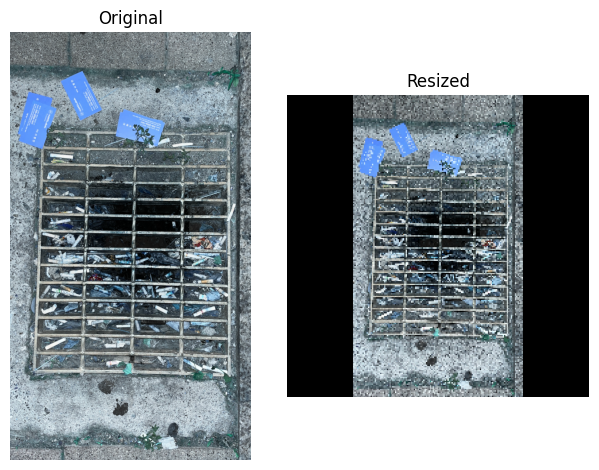

In [ ]:
# 이미지 리사이즈
image = cv2.imread('heavy/IMG_9514.JPG')
new_image = resize_image(image)

# 원본
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

# 출력
plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title('Resized')
plt.axis('off')

plt.tight_layout()
plt.show()

### 이미지 윤곽선 검출

In [3]:
# img = cv2.imread('clean/IMG_9380.JPG')
# img = cv2.imread('heavy/IMG_9514.JPG')
# img = cv2.imread('heavy_aug/IMG_9548_aug2.jpg')
img = cv2.imread('medium/IMG_9409.JPG')
new_img = resize_image(img)

# 이미지 채널 변경
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
# cv2.imshow('gray', gray)

# 이미지 이진화 수행
# 최대 임계값 : 255
# 임계 처리 : 가우시안 필터 사용 (블러 처리도 함께 적용됨)
# 임계치 처리 적용 영역 크기 : 9
# 평균이나 가중 평균에서 차감할 값 : 5
dst = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
# cv2.imshow('dst', ret)

# 이미지 블러 처리
# 노이즈를 줄이기 위함
gray = cv2.GaussianBlur(dst, (7, 7), 0)
# cv2.imshow('blured', gray)

# 이미지 경계선(픽셀의 값이 갑자기 커지거나 작아지는 부분) 검출
edged = cv2.Canny(gray, 100, 200)
# cv2.imshow('canny', edged)

# # 탐지한 경계선 두껍게 만들기
edged = cv2.dilate(edged, None, iterations=1)
# cv2.imshow('dilated', edged)

# 탐지한 경계선 얇게 만들기
edged = cv2.erode(edged, None, iterations=1)
# cv2.imshow('eroded', edged)

# 이미지 윤곽선 검출 (검출한 윤곽선 좌표, 계층 정보 리턴)
# cv2.RETR_EXTERNAL : 가장 바깥쪽 라인 검출
# cv2.CHAIN_APPROX_SIMPLE : 끝 점만 남기고 다른 점(수평, 수직, 대각선 방향)들은 모두 제거
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 가장 큰 윤곽선
largest_contour = max(contours, key=cv2.contourArea)
# 가장 큰 윤곽선 넓이 (단위 : 픽셀)
largest_area = cv2.contourArea(largest_contour)
print(largest_area)

# 결과 이미지
result_img = new_img.copy()
for i, contour in enumerate(contours) :
    mmt = cv2.moments(contour)
    # 윤곽선 중심점 계산
    cx = int(mmt['m10'] / mmt['m00'])
    cy = int(mmt['m01'] / mmt['m00'])
    # print(cx, cy)

    # 영역 넓이 (단위 : 픽셀)
    area = mmt['m00']
    # 영역 외곽선 길이
    length = cv2.arcLength(contour, True)

    # 윤곽선 표시 - 노란색
    cv2.drawContours(result_img, [contour], -1, (0, 255, 255), 2)
    
    # 윤곽선 중심점 표시 - 파란색
    cv2.circle(result_img, (cx, cy), 3, (255, 0, 0), -1)

    # 영역 넓이 표시
    cv2.putText(result_img, f'A : {area:.0f}', (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

    # 영역 외곽선 길이 표시
    cv2.putText(result_img, f'L : {length:.2f}', tuple(contour[0][0]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

    # 가장 큰 윤곽선 정보만 표시
    # if largest_area == area : 
    #     cv2.drawContours(result_img, [contour], -1, (0, 255, 255), 2)
        
    #     # 컨투어 중심점 표시
    #     cv2.circle(result_img, (cx, cy), 3, (255, 0, 0), -1)

    #     # 영역 넓이 표시
    #     cv2.putText(result_img, f'A : {area:.0f}', (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

    #     # 영역 외곽선 길이 표시
    #     cv2.putText(result_img, f'L : {length:.2f}', tuple(contour[0][0]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

    # 각 윤곽선별 넓이 계산
    print(f'area : {cv2.contourArea(contour, False):.2f}')

# 실제 면적 계산
# 픽셀 당 몇 cm 인지 안다는 가정이 필요
pixel_ratio = 50
largest_area_cm = largest_area / (pixel_ratio ** 2)
print(f'가장 큰 영역의 실제 면적 (추정) : {largest_area_cm:.2f} ㎠')

cv2.imshow('contours', result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

34598.5
area : 1.50
area : 12.50
area : 16.00
area : 5.00
area : 7.00
area : 88.50
area : 34598.50
가장 큰 영역의 실제 면적 (추정) : 13.84 ㎠


### ROI(Region Of Interest) 영역 추출

In [ ]:
# 원본 이미지 폴더 & 저장 폴더 설정
img_dir = 'heavy_62'
save_dir = 'roi'

# ROI 이미지 저장 디렉토리 생성
if not os.path.exists(save_dir) :
    os.makedirs(save_dir)

is_dragged = False
ix, iy = -1, -1
blue, yellow = (255, 0, 0), (0, 255, 255)

# 마우스 클릭하고 뗄 때, 이미지 위에 직사각형 그리는 함수
def onMouse(event, x, y, flags, param) :
    global is_dragged, ix, iy, blue, yellow

    # 마우스를 눌렀을 때, 초기 위치 저장
    if event == cv2.EVENT_LBUTTONDOWN :
        is_dragged = True
        ix, iy = x, y
    # 마우스를 드래그 할 때, 파란색 직사각형 그리기
    elif event == cv2.EVENT_MOUSEMOVE and is_dragged :
        img_draw = param.copy()
        cv2.rectangle(img_draw, (ix, iy), (x, y), blue, 1)
        cv2.imshow('Show Image', img_draw)
    # 마우스를 뗐을 때, 이미지 위에 노란색색 직사각형 그리기
    # ix, iy : 마우스 처음 클릭한 위치
    # x, y : 마우스 뗐을때의 그 위치
    # w, h : 직사각형 너비, 높이
    elif event == cv2.EVENT_LBUTTONUP :
        if is_dragged :
            is_dragged = False
            w = x - ix
            h = y - iy

            # 드래그한 직시각형 영역이 있을 때, 관심영역 찾기
            if w > 0 and h > 0 :
                cv2.rectangle(param, (ix, iy), (x, y), yellow, 1)
                cv2.imshow('Show Image', param)

                # 이미지에서 관심영역만 분리하여 새 창에 노출
                roi = param[iy:iy+h, ix:ix+w]
                cv2.imshow('ROI', roi)
                cv2.moveWindow('ROI', 500, 250)

                # 관심영역 이미지로 저장
                roi_filename = f'{save_dir}/roi_{os.path.basename(img_path)}'
                cv2.imwrite(roi_filename, roi)
                print(f'Saved: {roi_filename}')

# 지정된 이미지 디렉토리 순회
for filename in os.listdir(img_dir) :
    if filename.endswith('.JPG') or filename.endswith('.jpg') or filename.endswith('.jpeg') :
        img_path = os.path.join(img_dir, filename) 
        img = cv2.imread(img_path)

        # 이미지 리사이즈
        new_img = resize_image(img)
        cv2.imshow('Show Image', new_img)
        cv2.setMouseCallback('Show Image', onMouse, param=new_img)
        key = cv2.waitKey(0)

        # Space : 다음 페이지로 이동
        if key == 32 :
            cv2.destroyAllWindows()
            continue
        # ESC : 종료 
        elif key == 27 :
            break

cv2.destroyAllWindows()

Saved: roi/roi_heavy_1.jpeg
Saved: roi/roi_heavy_10.JPG
Saved: roi/roi_heavy_11.JPG
Saved: roi/roi_heavy_12.JPG
Saved: roi/roi_heavy_13.JPG
Saved: roi/roi_heavy_14.JPG
Saved: roi/roi_heavy_15.JPG
Saved: roi/roi_heavy_16.JPG
Saved: roi/roi_heavy_17.JPG
Saved: roi/roi_heavy_18.JPG
Saved: roi/roi_heavy_19.JPG
Saved: roi/roi_heavy_2.jpeg
Saved: roi/roi_heavy_20.JPG
Saved: roi/roi_heavy_21.jpg
Saved: roi/roi_heavy_22.jpg
Saved: roi/roi_heavy_23.jpg
Saved: roi/roi_heavy_24.jpg
Saved: roi/roi_heavy_25.jpg
Saved: roi/roi_heavy_26.jpg
Saved: roi/roi_heavy_27.jpg
Saved: roi/roi_heavy_28.jpg
Saved: roi/roi_heavy_29.jpg
Saved: roi/roi_heavy_3.JPG
Saved: roi/roi_heavy_30.jpg
Saved: roi/roi_heavy_31.jpg
Saved: roi/roi_heavy_32.jpg
Saved: roi/roi_heavy_33.jpg
Saved: roi/roi_heavy_34.jpg
Saved: roi/roi_heavy_35.jpg
Saved: roi/roi_heavy_36.jpg
Saved: roi/roi_heavy_37.jpg
Saved: roi/roi_heavy_38.jpg
Saved: roi/roi_heavy_39.jpg
Saved: roi/roi_heavy_4.JPG
Saved: roi/roi_heavy_40.jpg
Saved: roi/roi_heavy_4

그림자 비율: 11.73%


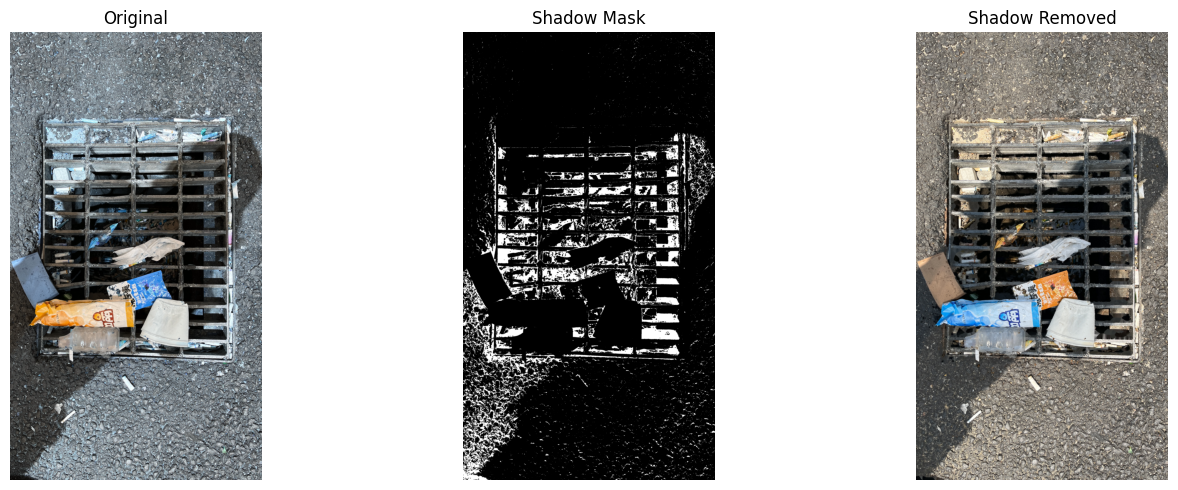

In [ ]:
image_path = 'heavy/IMG_9489.JPG'
img = cv2.imread(image_path)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# RGB 채널 이미지
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# HSV 채널 이미지
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# HSV에서 밝기 추출
# hue : 색깔
# saturation : 채도 (색의 진하고 연한 정도)
# value : 명도 (색의 밝고 어두운 정도)
hue, saturation, value = cv2.split(img_hsv)

# 그림자 마스크 생성
value_mask = cv2.inRange(value, 0, 40)
saturation_mask = cv2.inRange(saturation, 0, 80)
shadow_mask = cv2.bitwise_and(value_mask, saturation_mask)

# 모폴로지
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, kernel)

# 전체 픽셀 수와 그림자 픽셀 수 계산
total_pixels = shadow_mask.size
shadow_pixels = cv2.countNonZero(shadow_mask)
# 그림자 비율 계산
shadow_ratio = (shadow_pixels / total_pixels) * 100
print(f'그림자 비율: {shadow_ratio:.2f}%')

# 그림자 역마스크 생성
shadow_mask_inv = cv2.bitwise_not(shadow_mask)

# 그림자 제거
shadow_removed = cv2.inpaint(img_rgb, shadow_mask, 3, cv2.INPAINT_TELEA)

# 결과 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Shadow Mask')
plt.imshow(shadow_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Shadow Removed')
plt.imshow(shadow_removed)
plt.axis('off')

plt.tight_layout()
plt.show()